In [1]:
import pandas as pd

# load the streaming dataset
file_path = "C:\\Users\\user\\OneDrive - hull.ac.uk\\Understanding ai final assesment\\Streaming.csv"
df = pd.read_csv(file_path)



In [5]:
from sklearn.impute import SimpleImputer

# define the numerical features 
numerical_features = [
    "Age", "Subscription_Length", "Support_Tickets_Raised",
    "Satisfaction_Score", "Discount_Offered", "Last_Activity"
]

# drop rows with missing target
df = df.dropna(subset=["Monthly_Spend"])

# imputes missing numerical features with mean
imputer = SimpleImputer(strategy="mean")
df[numerical_features] = imputer.fit_transform(df[numerical_features])

# confirms no missing values remain in selected columns
df[numerical_features + ["Monthly_Spend"]].isnull().sum()


Age                       0
Subscription_Length       0
Support_Tickets_Raised    0
Satisfaction_Score        0
Discount_Offered          0
Last_Activity             0
Monthly_Spend             0
dtype: int64

A.

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# prepares output dataframe to same results
results = []

# the target variable
y = df["Monthly_Spend"].values

# loops through numerical features
for feature in numerical_features:
    X = df[[feature]].values

    # linear regression
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    y_pred_lin = lin_model.predict(X)
    lin_r2 = r2_score(y, y_pred_lin)
    lin_mse = mean_squared_error(y, y_pred_lin)

    # polynomial regression(degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    poly_r2 = r2_score(y, y_pred_poly)
    poly_mse = mean_squared_error(y, y_pred_poly)

    # save results
    results.append({
        "Feature": feature,
        "Linear R²": lin_r2,
        "Linear MSE": lin_mse,
        "Poly R²": poly_r2,
        "Poly MSE": poly_mse
    })

# converts to dataframe
results_df = pd.DataFrame(results)
print(results_df)



                  Feature  Linear R²  Linear MSE   Poly R²   Poly MSE
0                     Age   0.000048   90.648684  0.000095  90.644363
1     Subscription_Length   0.298858   63.560660  0.298868  63.559776
2  Support_Tickets_Raised   0.025907   88.304441  0.026302  88.268671
3      Satisfaction_Score   0.521102   43.413563  0.521111  43.412691
4        Discount_Offered   0.046653   86.423781  0.046664  86.422809
5           Last_Activity   0.000024   90.650839  0.000054  90.648127


B.

In [7]:
from sklearn.model_selection import train_test_split

# features and target
X = df[numerical_features]
y = df["Monthly_Spend"]

# split test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# numerical values of linear regression
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)
y_pred_multi = multi_model.predict(X_test)

# evaluation
multi_r2 = r2_score(y_test, y_pred_multi)
multi_mse = mean_squared_error(y_test, y_pred_multi)

multi_r2, multi_mse


(0.8861717107036946, 10.290140097999448)

C.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# numerical and categoriacal values defined 
categorical_features = ["Gender", "Region", "Payment_Method"]

# sets up the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# build pipeline for preprocessing + model
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# train/test split
X = df[numerical_features + categorical_features]
y = df["Monthly_Spend"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fitting & prediction
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)


rf_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)

rf_r2, rf_mse


(0.86791272669547, 11.940762317250009)

D.

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# define features
numerical_features = ["Age", "Subscription_Length", "Support_Tickets_Raised",
                      "Satisfaction_Score", "Discount_Offered", "Last_Activity"]
categorical_features = ["Gender", "Region", "Payment_Method"]

X = df[numerical_features + categorical_features]
y = df["Monthly_Spend"]

# preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# define ANN
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# early stopping traininig
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[early_stop], verbose=1)

# to predit and evaluate
y_pred = model.predict(X_test).flatten()

from sklearn.metrics import mean_squared_error, r2_score
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Epoch 1/100


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2088.4851 - val_loss: 942.8096
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 520.2759 - val_loss: 83.1465
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.2540 - val_loss: 67.7266
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.9279 - val_loss: 56.3284
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.7356 - val_loss: 47.6960
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46.4284 - val_loss: 40.6217
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.4493 - val_loss: 35.9435
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.8513 - val_loss: 32.0317
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9608 - val_loss: 27.7741
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.3136 - val_loss: 25.0086
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.4282 - val_loss: 22.0792
Epoch 12/100
100/100 ━━━━━━

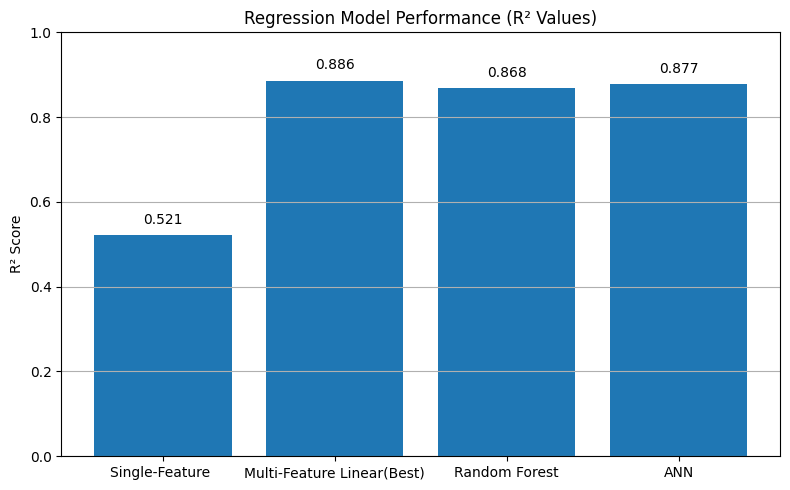

In [23]:
import matplotlib.pyplot as plt


model_names = ["Single-Feature ", "Multi-Feature Linear(Best)", "Random Forest", "ANN"]
r2_scores = [0.521, 0.886, 0.868, 0.877]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, r2_scores)
plt.ylim(0, 1)
plt.title("Regression Model Performance (R² Values)")
plt.ylabel("R² Score")
plt.grid(axis='y')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


F.

In [11]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


df = pd.read_csv("Streaming.csv")


df = df.dropna(subset=["Monthly_Spend", "Age", "Satisfaction_Score"])


numerical_features = [
    "Age", "Subscription_Length", "Support_Tickets_Raised",
    "Satisfaction_Score", "Discount_Offered", "Last_Activity"
]
categorical_features = ["Gender", "Region", "Payment_Method"]
X = df[numerical_features + categorical_features]
y = df["Churned"]

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

# tranforms data
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# model training
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# model prediction
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# function evaluation
def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n {name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_prob))


evaluate_model("Logistic Regression", y_test, y_pred_log, y_prob_log)
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)



 Logistic Regression Evaluation
Accuracy: 0.812577065351418
Precision: 0.8099415204678363
Recall: 0.760989010989011
F1 Score: 0.7847025495750708
AUC-ROC: 0.8870061705632176

 Random Forest Evaluation
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0


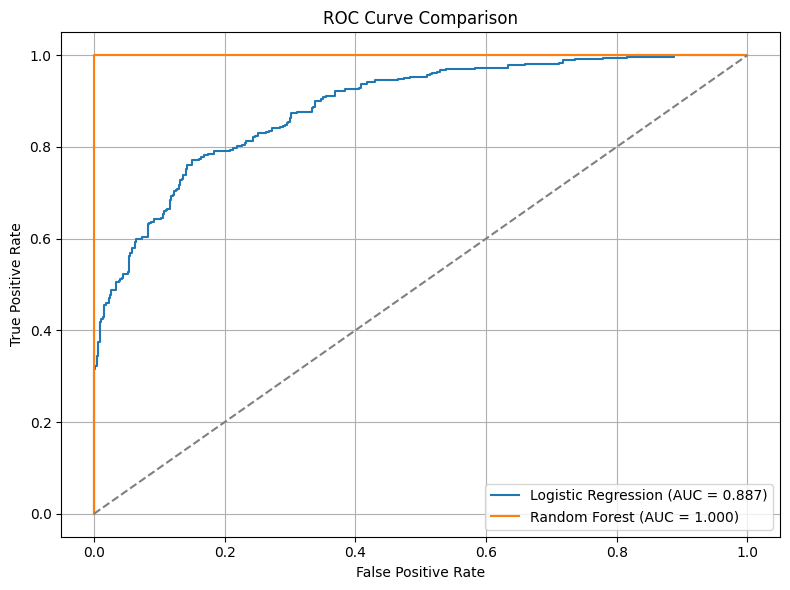

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

numerical_features = [
    "Age", "Subscription_Length", "Support_Tickets_Raised",
    "Satisfaction_Score", "Discount_Offered", "Last_Activity"
]
categorical_features = ["Gender", "Region", "Payment_Method"]
X = df[numerical_features + categorical_features]
y = df["Churned"]


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# model training
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# model prediction
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# evaluation metrics
metrics_data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf)
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf)
    ]
}


df_metrics = pd.DataFrame(metrics_data)

# ROC curve plot
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {metrics_data['AUC-ROC'][0]:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {metrics_data['AUC-ROC'][1]:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




G.

In [14]:
import pandas as pd


X = df.copy()

# Drop target variables if present
X = X.drop(['Monthly Spend', 'Churn'], axis=1, errors='ignore')

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Normalize or scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


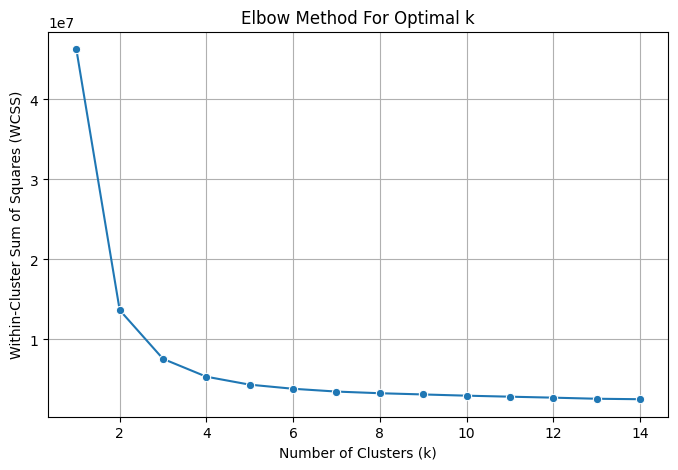

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


wcss = []
K = range(1, 15)  # Trying k from 1 to 14

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) 
    
# plotting the Elbow graph
plt.figure(figsize=(8, 5))
sns.lineplot(x=K, y=wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

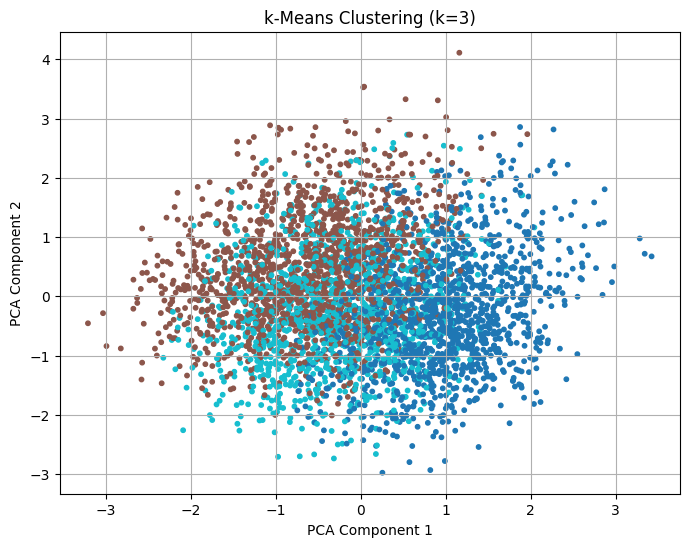

Silhouette Score: 0.11624635802350612


In [25]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numerical_features = ["Age", "Subscription_Length", "Support_Tickets_Raised",
                      "Satisfaction_Score", "Discount_Offered", "Last_Activity"]
X = df[numerical_features]

# data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-Means with k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# adding cluster labels to the dataframe
df["Cluster"] = clusters


X_pca = PCA(n_components=2).fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("k-Means Clustering (k=3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
print("Silhouette Score:", silhouette_score(X_scaled, clusters))


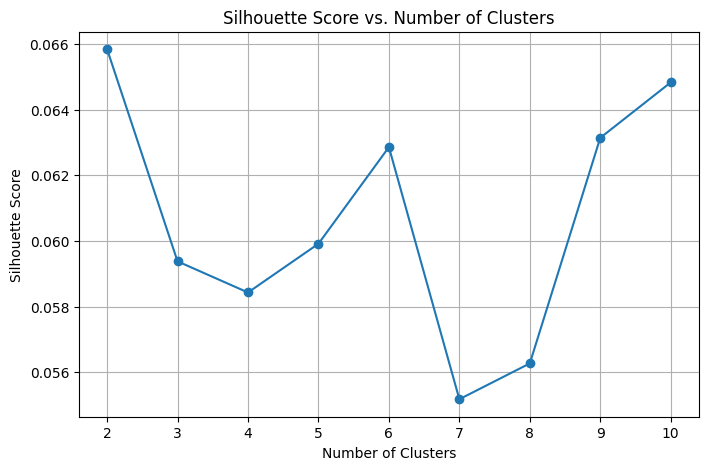

In [26]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    labels = fcluster(linked, t=k, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


H.

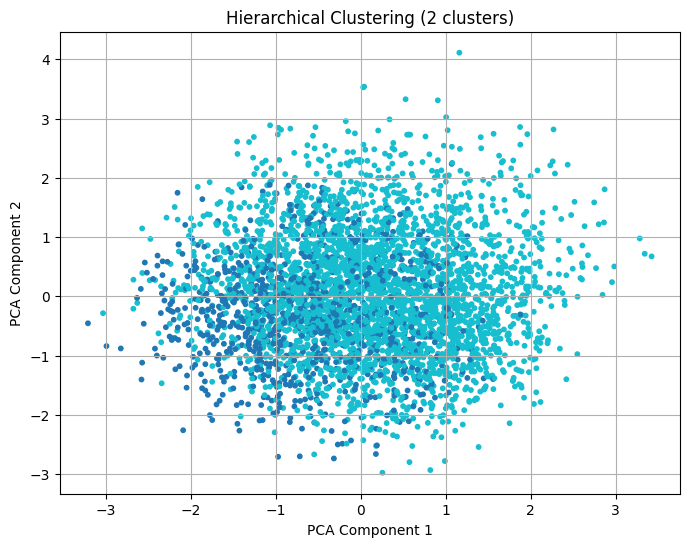

Silhouette Score: 0.06583585556720457


In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
df = pd.read_csv("Streaming.csv")


numerical_features = [
    "Age", "Subscription_Length", "Support_Tickets_Raised",
    "Satisfaction_Score", "Discount_Offered", "Last_Activity"
]
df = df.dropna(subset=numerical_features)
X = df[numerical_features]

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical clustering
linked = linkage(X_scaled, method="ward")

# form 2 clusters
hier_labels = fcluster(linked, t=2, criterion="maxclust")
df["Hierarchical_Cluster"] = hier_labels

# Visualize with PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap='tab10', s=10)
plt.title("Hierarchical Clustering (2 clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# Evaluate
print("Silhouette Score:", silhouette_score(X_scaled, hier_labels))



In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# standardized data
X_scaled = scaler.fit_transform(df[numerical_features])

# DBSCAN 
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# filter out noise(-1) 
mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1 and mask.sum() > 1:
    dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
else:
    dbscan_silhouette = "Not applicable (too much noise)"

# visualize DBSCAN clusters using PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap="tab10", s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# silhouette score
len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0), dbscan_silhouette


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)